In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms
from PIL import Image
from torchvision.io import read_image
from torch import nn
import torch.nn.functional as F
import time
import random
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data import SubsetRandomSampler
from torchvision.utils import make_grid
from torchvision import datasets


%matplotlib inline


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
#set random seed so input is the same each run
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#make deterministic
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0003
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

plt.ion()   # interactive mode

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Mounted at /content/drive


In [4]:
#some helper functions
def get_dataloaders_cifar10(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None,
                            test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=train_transforms,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

def train_classifier_simple_v1(num_epochs, model, optimizer, device, 
                               train_loader, valid_loader=None, 
                               loss_fn=None, logging_interval=100, 
                               skip_epoch_stats=False):
    
    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}
    
    if loss_fn is None:
        loss_fn = F.cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (shape, texture, features) in enumerate(train_loader):

            features = features.to(device)
            shape=shape.to(device)
            texture=texture.to(device)
            #CHANGE HERE FOR TEXTRE OR SHAPE
            targets=texture

            # FORWARD AND BACK PROP
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_acc = compute_accuracy(model, train_loader, device)
                train_loss = compute_epoch_loss(model, train_loader, device)
                print('***Epoch: %03d/%03d | Train. Acc.: %.3f%% | Loss: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss(model, valid_loader, device)
                    print('***Epoch: %03d/%03d | Valid. Acc.: %.3f%% | Loss: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    return log_dict

def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (shape, texture, features) in enumerate(data_loader):
            features = features.to(device)
            shape = shape.to(device)
            texture= texture.to(device)
            ##change here to switch between shape and texture learning
            targets=texture
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def compute_epoch_loss(model, data_loader, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for shape, texture, features in data_loader:
            features = features.to(device)
            shape = shape.to(device)
            texture=texture.to(device)
            #CHANGE THIS too!!!(@(#)!)(@#()!@#)
            targets=texture
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [5]:
class StylizedCifar10(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        shape = self.img_labels.iloc[idx, 1]
        texture= self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            shape = self.target_transform(shape)
            texture= self.target_transform(texture)
        return shape, texture, image

In [6]:
stylized_cifar=StylizedCifar10(annotations_file='/content/drive/MyDrive/annotations.csv', 
                               img_dir='/content/drive/MyDrive/stylized_cifar_save',
                               transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize(70),transforms.ToTensor()]))
#test_loader=DataLoader(stylized_cifar, batch_size=64)

train_size = int(0.8 * len(stylized_cifar))
test_size = len(stylized_cifar) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(stylized_cifar, [train_size, test_size])
train_loader=DataLoader(train_dataset, batch_size=64)
test_loader=DataLoader(test_dataset, batch_size=64)

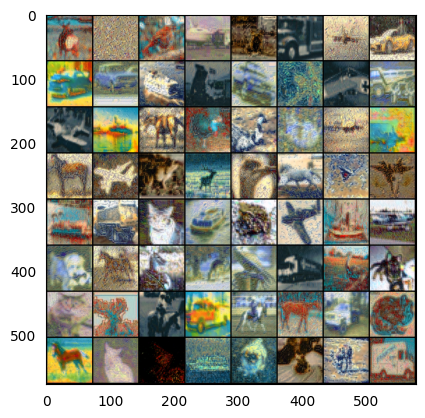

deer  plane bird  ship  cat   truck plane car  

Testing Set:
Image batch dimensions: torch.Size([64, 3, 70, 70])
Image shape label dimensions: torch.Size([64])
Image texture label dimensions: torch.Size([64])


In [7]:
#look at some of the dataset

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
shape, texture, image = next(dataiter)

for i in [0]:
  shape, texture, image = next(dataiter)
  # show images
  plt.tick_params(left = False, bottom = False)
  imshow(make_grid(image))
  # print labels
  print(' '.join(f'{classes[shape[j]]:5s}' for j in range(8)))
print('\nTesting Set:')
for shape, texture, images in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image shape label dimensions:', shape.size())
    print('Image texture label dimensions:', texture.size())
    break

In [8]:
##########################
### MODEL
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits



In [9]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [10]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, 
                                      logging_interval=50)

#save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/alexnet_stylized_cifar_texture.pt')

Epoch: 001/040 | Batch 0000/0051 | Loss: 2.3041
Epoch: 001/040 | Batch 0050/0051 | Loss: 1.7511
***Epoch: 001/040 | Train. Acc.: 12.184% | Loss: 2.242
Time elapsed: 38.06 min
Epoch: 002/040 | Batch 0000/0051 | Loss: 2.1957
Epoch: 002/040 | Batch 0050/0051 | Loss: 1.4779
***Epoch: 002/040 | Train. Acc.: 45.065% | Loss: 1.330
Time elapsed: 40.27 min
Epoch: 003/040 | Batch 0000/0051 | Loss: 1.4922
Epoch: 003/040 | Batch 0050/0051 | Loss: 0.9932
***Epoch: 003/040 | Train. Acc.: 53.146% | Loss: 1.232
Time elapsed: 42.47 min
Epoch: 004/040 | Batch 0000/0051 | Loss: 1.4544
Epoch: 004/040 | Batch 0050/0051 | Loss: 0.8771
***Epoch: 004/040 | Train. Acc.: 69.988% | Loss: 0.611
Time elapsed: 44.65 min
Epoch: 005/040 | Batch 0000/0051 | Loss: 0.7289
Epoch: 005/040 | Batch 0050/0051 | Loss: 0.7144
***Epoch: 005/040 | Train. Acc.: 81.925% | Loss: 0.562
Time elapsed: 46.84 min
Epoch: 006/040 | Batch 0000/0051 | Loss: 0.6258
Epoch: 006/040 | Batch 0050/0051 | Loss: 0.2928
***Epoch: 006/040 | Train. Ac

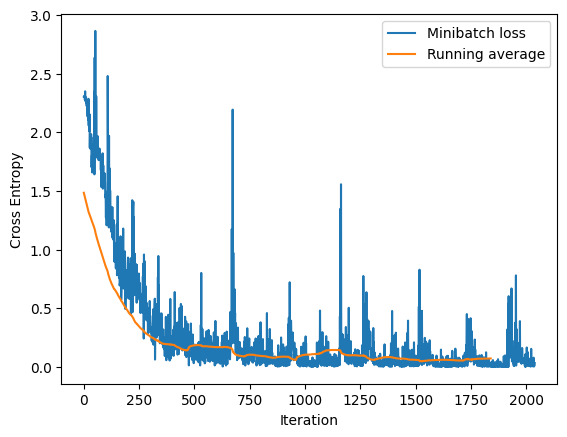

In [11]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

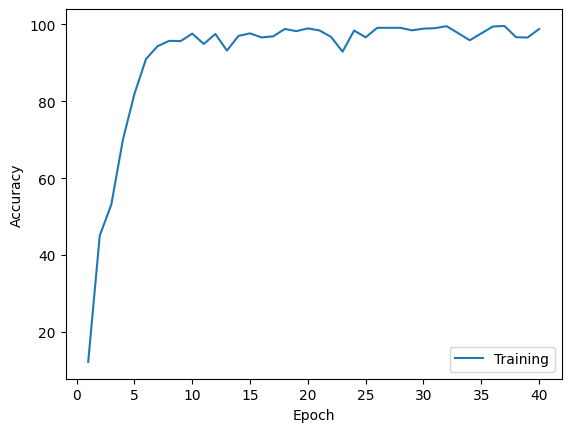

In [12]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
#plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
#model = AlexNet(NUM_CLASSES)
#model.load_state_dict(torch.load('/content/drive/MyDrive/alexnet_stylized_cifar_shape.pt'))
#model.eval()
#model.to(DEVICE)

with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)

    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 98.83%
Test ACC: 97.90%
